## OBJECTIVE: ##
    Given a set of anonymized categorical variables, come up with a predective model to figure a server will be hacked or not.
    

In [412]:
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn.preprocessing import StandardScaler
from scipy.sparse import csr_matrix
from scipy import sparse
from sklearn import metrics
from sklearn import preprocessing
from sklearn.metrics import recall_score
import matplotlib.pyplot as plt
import seaborn as sns
import os
import time
import warnings
import numpy as np
from sklearn.metrics import confusion_matrix
from datetime import datetime
from sklearn.model_selection import train_test_split
from scipy.sparse import hstack
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
import scipy.stats as st

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from xgboost.sklearn import XGBClassifier

warnings.filterwarnings("ignore")

In [28]:
import os
cwd = os.getcwd()
print(cwd)

C:\Users\rahul\Desktop\Novartis Challenge


## Exploratory Data Analysis: ##

In [241]:
#C:\Users\rahul\Desktop\Novartis Challenge\Dataset
data = pd.read_csv('C:\\Users\\rahul\\Desktop\\Novartis Challenge\\Dataset\\Train.csv',encoding='utf-8')
data.head()

,INCIDENT_ID,DATE,X_1,X_2,X_3,X_4,X_5,X_6,X_7,X_8,X_9,X_10,X_11,X_12,X_13,X_14,X_15,MULTIPLE_OFFENSE
0,CR_102659,04-JUL-04,0,36,34,2,1,5,6,1,6,1,174,1.0,92,29,36,0
1,CR_189752,18-JUL-17,1,37,37,0,0,11,17,1,6,1,236,1.0,103,142,34,1
2,CR_184637,15-MAR-17,0,3,2,3,5,1,0,2,3,1,174,1.0,110,93,34,1
3,CR_139071,13-FEB-09,0,33,32,2,1,7,1,1,6,1,249,1.0,72,29,34,1
4,CR_109335,13-APR-05,0,33,32,2,1,8,3,0,5,1,174,0.0,112,29,43,1


In [242]:
data.describe

<bound method NDFrame.describe of       INCIDENT_ID       DATE  X_1  X_2  X_3  X_4  X_5  X_6  X_7  X_8  X_9  \
0       CR_102659  04-JUL-04    0   36   34    2    1    5    6    1    6   
1       CR_189752  18-JUL-17    1   37   37    0    0   11   17    1    6   
2       CR_184637  15-MAR-17    0    3    2    3    5    1    0    2    3   
3       CR_139071  13-FEB-09    0   33   32    2    1    7    1    1    6   
4       CR_109335  13-APR-05    0   33   32    2    1    8    3    0    5   
...           ...        ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
23851    CR_88991  11-JAN-02    1   47   48    7    3   15   10    1    5   
23852    CR_46369  05-FEB-97    0   33   32    2    1    5    6    0    5   
23853   CR_157556  03-APR-12    0   25   25    9    0    3    5    1    6   
23854   CR_103180  25-JAN-04    0   39   39    6    5    2    7    1    6   
23855    CR_22575  08-NOV-94    7   36   34    2    1    9    8    0    5   

       X_10  X_11  X_12  X_13  X_14  X_15

In [243]:
#Find unique values across each column
print (data.apply(lambda x: x.nunique()))

INCIDENT_ID         23856
DATE                 9121
X_1                     8
X_2                    52
X_3                    52
X_4                    10
X_5                     5
X_6                    19
X_7                    19
X_8                    24
X_9                     7
X_10                   24
X_11                  133
X_12                   23
X_13                   60
X_14                   62
X_15                   28
MULTIPLE_OFFENSE        2
dtype: int64


In [244]:
#Check the values in each class
print("The number of data points in each class are: ",data['MULTIPLE_OFFENSE'].value_counts())

The number of data points in each class are:  1    22788
0     1068
Name: MULTIPLE_OFFENSE, dtype: int64


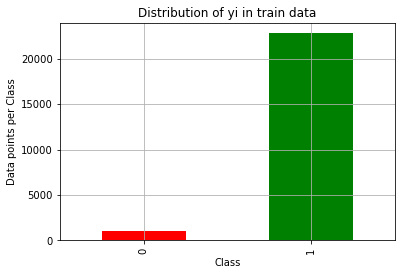

Number of data points in class 2 : 22788 ( 95.523 %)
Number of data points in class 1 : 1068 ( 4.477 %)


In [245]:
#It can be seen that the dataset is extremely imbalanced

class_distribution = data['MULTIPLE_OFFENSE'].value_counts().sort_index()

my_colors = ['r','g']
class_distribution.plot(kind='bar',color=my_colors)
plt.xlabel('Class')
plt.ylabel('Data points per Class')
plt.title('Distribution of yi in train data')
plt.grid()
plt.show()

# ref: argsort https://docs.scipy.org/doc/numpy/reference/generated/numpy.argsort.html
# -(train_class_distribution.values): the minus sign will give us in decreasing order
sorted_yi = np.argsort(-class_distribution.values)
for i in sorted_yi:
    print('Number of data points in class', i+1, ':',class_distribution.values[i], '(', np.round((class_distribution.values[i]/data.shape[0]*100), 3), '%)')


In [289]:
# This function plots the confusion matrices given y_i, y_i_hat.
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    A =(((C.T)/(C.sum(axis=1))).T)

    
    B =(C/C.sum(axis=0))
    
    labels = [0,1]
    plt.figure(figsize=(20,4))
    cmap=sns.light_palette("blue")
    # representing A in heatmap format
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")

    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    plt.show()

## Time based slicing and Featurizations(Response coding) :

In [247]:
#perform time based slice as date column is available
months = {'JAN': '01','FEB': '02','MAR': '03','APR': '04','MAY': '05','JUN': '06','JUL': '07','AUG': '08','SEP': '09','OCT': '10','NOV': '11','DEC': '12'}
dates = data['DATE'].values.tolist()
for date in dates:
    date.upper()

print(len(dates))

conv_dates = []
for date in dates:
    for month in months:
        if month in date:
            conv_date = date.replace(month, months[month])
            conv_dates.append(conv_date)
print(conv_dates[:10])

print(len(conv_dates))

23856
['04-07-04', '18-07-17', '15-03-17', '13-02-09', '13-04-05', '07-04-03', '22-01-08', '14-05-93', '21-08-16', '25-08-96']
23856


In [248]:
# convert any year further than current year to 20th century as no servers existed before that
# a ='rahul'
# print(a[-2:])
# print(a[:-2])
final_dates = []
for date in conv_dates:
    if (int(date[-2:]) > 20):
        final_date = date[:-2] + '19' + date[-2:] 
        final_dates.append(final_date)
    else:
        final_date = date[:-2] + '20' + date[-2:]
        final_dates.append(final_date)

print(final_dates[:10])
print(len(final_dates))

['04-07-2004', '18-07-2017', '15-03-2017', '13-02-2009', '13-04-2005', '07-04-2003', '22-01-2008', '14-05-1993', '21-08-2016', '25-08-1996']
23856


In [249]:
new_df = data
new_df['DATE'] = final_dates
new_df.sort_values(by='DATE')

#Sorting data according to Date in ascending order
sorted_data=new_df.sort_values('DATE')
print(sorted_data.head())

      INCIDENT_ID        DATE  X_1  X_2  X_3  X_4  X_5  X_6  X_7  X_8  X_9  \
19022     CR_1141  01-01-1991    0   22   22    7    3    8    3    7    2   
4497      CR_6143  01-01-1992    0   21   23    4    1    2    7    1    6   
18978     CR_7504  01-01-1992    0   33   32    2    1    8    3    0    5   
13464    CR_16081  01-01-1993    0   36   34    2    1    1    0    0    5   
13038    CR_16226  01-01-1993    1   36   34    2    1   15   10    1    6   

       X_10  X_11  X_12  X_13  X_14  X_15  MULTIPLE_OFFENSE  
19022     2     0   2.0    72   142    34                 1  
4497      1   174   1.0   103    80    34                 1  
18978     1   174   0.0    72   142    48                 1  
13464     1   174   0.0   103    93    43                 1  
13038     1   249   1.0    92    29    34                 1  


In [250]:
#Find number of NaN values in DF if its very small lets drop them else follow imputation techniques
print("The number of NaN values in the data is: ",len(sorted_data)-sorted_data.count())
print("The percentage of missing values is: {} % ".format(((len(sorted_data)-sorted_data.count()).sum()*100/len(sorted_data)).round(3)))

The number of NaN values in the data is:  INCIDENT_ID           0
DATE                  0
X_1                   0
X_2                   0
X_3                   0
X_4                   0
X_5                   0
X_6                   0
X_7                   0
X_8                   0
X_9                   0
X_10                  0
X_11                  0
X_12                182
X_13                  0
X_14                  0
X_15                  0
MULTIPLE_OFFENSE      0
dtype: int64
The percentage of missing values is: 0.763 % 


In [252]:
#since the missing values are very less lets drop them
sorted_data = sorted_data.dropna()

#Performing the standard train test split of 80-20
y_labels = sorted_data['MULTIPLE_OFFENSE'].values
# sorted_data = sorted_data.drop(columns = 'MULTIPLE_OFFENSE')

# split the data into test and train by maintaining same distribution of output varaible 'y_true' [stratify=y_true]
X_train, X_test, y_train, y_test = train_test_split(sorted_data, y_labels, stratify=y_labels, test_size=0.1)
print(len(X_train))
print(len(X_test))

21306
2368


# EDA on Random features(value counts and Histogram) :

In [253]:
def plot_univariate(feature):
    s = sum(feature.values);
    h = feature.values/s;
    plt.plot(h, label="Histrogram ")
    plt.xlabel('Index ')
    plt.ylabel('Number of Occurances')
    plt.legend()
    plt.grid()
    plt.show()


In [254]:
X_train['X_1'].value_counts()

0    16969
1     3152
7      788
5      247
3      112
4       25
2        9
6        4
Name: X_1, dtype: int64

In [255]:
unique_x1 = X_train['X_1'].value_counts()
print('Number of Unique x1 :', unique_x1.shape[0])

print(unique_x1.head(8))

Number of Unique x1 : 8
0    16969
1     3152
7      788
5      247
3      112
4       25
2        9
6        4
Name: X_1, dtype: int64


HISTOGRAM of X1's


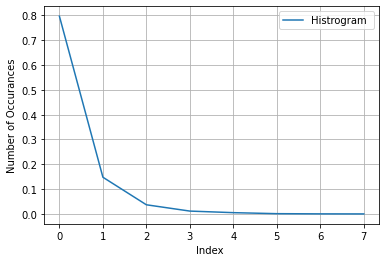

In [256]:
print("HISTOGRAM of X1's")
plot_univariate(unique_x1)

In [257]:
unique_x3 = X_train['X_3'].value_counts()
print('Number of Unique x3 :', unique_x1.shape[0])

print(unique_x3.head(8))

Number of Unique x3 : 8
4     3605
34    1951
32    1931
24    1199
23    1122
37     877
49     831
45     813
2      688
22     612
Name: X_3, dtype: int64


HISTOGRAM of X3's


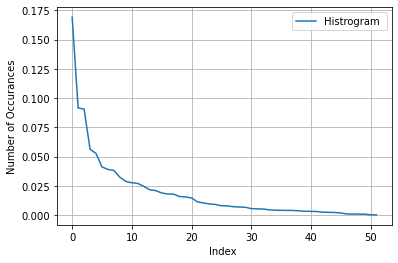

In [258]:
print("HISTOGRAM of X3's")
plot_univariate(unique_x3)

In [259]:
unique_x11 = X_train['X_11'].value_counts()
print('Number of Unique x11 :', unique_x11.shape[0])
# the top 10 that occured most
print(unique_x11.head(10))

Number of Unique x11 : 125
174    6424
249    6214
316    4064
0      2271
303     400
127     269
74      193
179     186
102     109
263      90
Name: X_11, dtype: int64


HISTOGRAM of X11's


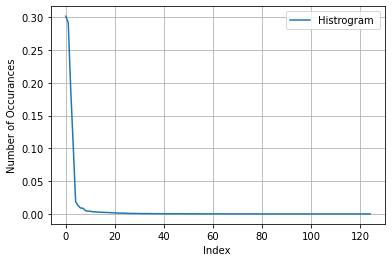

In [260]:
print("HISTOGRAM of X11's")
plot_univariate(unique_x11)

### OBSERVATIONS FROM EDA: ###
    1. It was observed that data was highly imbalanced to the ratio of 95 percent(hacked) to 5 percent(not hacked).
    2. It is important to come up with right techniques to handle this high imbalance.
    3. All categorical values had different kind of distributions with some having fewer categories and some having many categories

# Featurizations (Response Coding and one hot encoding) : 

In [261]:
## Response Coding for features 

def get_xi_fea_dict(alpha, feature, df):
    # value_count: it contains a dict like
    value_count = X_train[feature].value_counts()
    
    xi_dict = dict()
    
    # denominator will contain the number of time that particular feature occured in whole data
    for i, denominator in value_count.items():
        # vec will contain (p(yi==1/xi) probability of feature belongs to perticular class
        # vec is 2 diamensional vector
        vec = []
        for k in range(2):

            cls_cnt = X_train.loc[(X_train['MULTIPLE_OFFENSE']==k) & (X_train[feature]==i)]
            
            # cls_cnt.shape[0](numerator) will contain the number of time that particular feature occured in whole data
            vec.append((cls_cnt.shape[0] + alpha*1)/ (denominator + 2*alpha))

        xi_dict[i]=vec
    return xi_dict

def get_xi_feature(alpha, feature, df):

    xi_dict = get_xi_fea_dict(alpha, feature, df)
    
    value_count = X_train[feature].value_counts()
    
    xi_fea = []
    # if not we will add [1/2,1/2] to xi_fea
    for index, row in df.iterrows():
        if row[feature] in dict(value_count).keys():
            xi_fea.append(xi_dict[row[feature]])
        else:
            xi_fea.append([1/2,1/2])

    return xi_fea

In [262]:
alpha = 1

train_x1_feature_responseCoding = np.array(get_xi_feature(alpha, "X_1", X_train))

test_x1_feature_responseCoding = np.array(get_xi_feature(alpha, "X_1", X_test))

train_x2_feature_responseCoding = np.array(get_xi_feature(alpha, "X_2", X_train))

test_x2_feature_responseCoding = np.array(get_xi_feature(alpha, "X_2", X_test))


print("train_x1_feature_responseCoding is converted feature using respone coding method. The shape of feature:", train_x1_feature_responseCoding.shape)

train_x1_feature_responseCoding is converted feature using respone coding method. The shape of feature: (21306, 2)


In [263]:
#Converting all other 14 features into response coded features
train_x3_feature_responseCoding = np.array(get_xi_feature(alpha, "X_3", X_train))
test_x3_feature_responseCoding = np.array(get_xi_feature(alpha, "X_3", X_test))

train_x4_feature_responseCoding = np.array(get_xi_feature(alpha, "X_4", X_train))
test_x4_feature_responseCoding = np.array(get_xi_feature(alpha, "X_4", X_test))

train_x5_feature_responseCoding = np.array(get_xi_feature(alpha, "X_5", X_train))
test_x5_feature_responseCoding = np.array(get_xi_feature(alpha, "X_5", X_test))

train_x6_feature_responseCoding = np.array(get_xi_feature(alpha, "X_6", X_train))
test_x6_feature_responseCoding = np.array(get_xi_feature(alpha, "X_6", X_test))

train_x7_feature_responseCoding = np.array(get_xi_feature(alpha, "X_7", X_train))
test_x7_feature_responseCoding = np.array(get_xi_feature(alpha, "X_7", X_test))

train_x8_feature_responseCoding = np.array(get_xi_feature(alpha, "X_8", X_train))
test_x8_feature_responseCoding = np.array(get_xi_feature(alpha, "X_8", X_test))

train_x9_feature_responseCoding = np.array(get_xi_feature(alpha, "X_9", X_train))
test_x9_feature_responseCoding = np.array(get_xi_feature(alpha, "X_9", X_test))

train_x10_feature_responseCoding = np.array(get_xi_feature(alpha, "X_10", X_train))
test_x10_feature_responseCoding = np.array(get_xi_feature(alpha, "X_10", X_test))

train_x11_feature_responseCoding = np.array(get_xi_feature(alpha, "X_11", X_train))
test_x11_feature_responseCoding = np.array(get_xi_feature(alpha, "X_11", X_test))

train_x12_feature_responseCoding = np.array(get_xi_feature(alpha, "X_12", X_train))
test_x12_feature_responseCoding = np.array(get_xi_feature(alpha, "X_12", X_test))

train_x13_feature_responseCoding = np.array(get_xi_feature(alpha, "X_13", X_train))
test_x13_feature_responseCoding = np.array(get_xi_feature(alpha, "X_13", X_test))

train_x14_feature_responseCoding = np.array(get_xi_feature(alpha, "X_14", X_train))
test_x14_feature_responseCoding = np.array(get_xi_feature(alpha, "X_14", X_test))

train_x15_feature_responseCoding = np.array(get_xi_feature(alpha, "X_15", X_train))
test_x15_feature_responseCoding = np.array(get_xi_feature(alpha, "X_15", X_test))


In [264]:
#stacking all the response coded vectors
train_features_responseCoding = np.concatenate((train_x1_feature_responseCoding,train_x2_feature_responseCoding,train_x3_feature_responseCoding,train_x4_feature_responseCoding,train_x5_feature_responseCoding,train_x6_feature_responseCoding,train_x7_feature_responseCoding,train_x8_feature_responseCoding,train_x9_feature_responseCoding,train_x10_feature_responseCoding,train_x11_feature_responseCoding,train_x12_feature_responseCoding,train_x13_feature_responseCoding,train_x14_feature_responseCoding,train_x15_feature_responseCoding),axis=-1)
test_features_responseCoding =  np.concatenate((test_x1_feature_responseCoding,test_x2_feature_responseCoding,test_x3_feature_responseCoding,test_x4_feature_responseCoding,test_x5_feature_responseCoding,test_x6_feature_responseCoding,test_x7_feature_responseCoding,test_x8_feature_responseCoding,test_x9_feature_responseCoding,test_x10_feature_responseCoding,test_x11_feature_responseCoding,test_x12_feature_responseCoding,test_x13_feature_responseCoding,test_x14_feature_responseCoding,test_x15_feature_responseCoding),axis=-1)

print("train_features_responseCoding is converted feature using respone coding method. The shape of feature:", train_features_responseCoding.shape)
print("test_features_responseCoding is converted feature using respone coding method. The shape of feature:", test_features_responseCoding.shape)

train_features_responseCoding is converted feature using respone coding method. The shape of feature: (21306, 30)
test_features_responseCoding is converted feature using respone coding method. The shape of feature: (2368, 30)


## Try OneHotEncoding (might not be a good idea!): 

In [266]:
#Find the sum of unique categoical values in from x1 to x15 

cat_values = []
for col in X_train.loc[:, 'X_1':'X_15'].columns:
        cat_values.append(X_train[col].unique())
print(len(cat_values))
cat_values=list(cat_values)

print(len(cat_values))

total_cat = 0
for i in range(len(cat_values)):
    total_cat += len(cat_values[i])

print("The sum of categorical variables between X1 and X15 is: ",total_cat)

X_train_clean = X_train.loc[:,'X_1':'X_15'].dropna()
X_test_clean = X_test.loc[:,'X_1':'X_15'].dropna()

X_train_clean = X_train_clean.astype(int) 
X_test_clean = X_test_clean.astype(int)

print(X_train_clean.head())
# Use one hot encoding to add those features and 
ohe = OneHotEncoder(handle_unknown='ignore')
X_train_ohe = ohe.fit_transform(X_train_clean).toarray()
X_test_ohe = ohe.transform(X_test_clean).toarray()
feature_labels = ohe.categories_

print(feature_labels)
print("The shape of one hot encoded train features is: ",X_train_ohe.shape)
print("The shape of one hot encoded test features is: ",X_test_ohe.shape)

15
15
The sum of categorical variables between X1 and X15 is:  509
       X_1  X_2  X_3  X_4  X_5  X_6  X_7  X_8  X_9  X_10  X_11  X_12  X_13  \
1022     0   36   34    2    1    5    6    1    6     1   249     1   103   
13874    0   26   27    9    0    3    5    1    2     1   316     1    98   
17452    0   47   48    7    3    4    2    0    5     1   316     1    72   
18886    0   24   24    0    0    5    6    2    6     3   249     3   103   
1632     0   24   24    0    0    7    1    2    2     2   102     2    92   

       X_14  X_15  
1022     29    34  
13874   142    34  
17452    29    34  
18886   130    34  
1632    142    34  
[array([0, 1, 2, 3, 4, 5, 6, 7]), array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
       52]), array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 13, 14, 15, 16, 1

NOTE on featurizations:
    1. As all the 15 anonymized features were categorical, we came up with two featurization methods a. Response Coding b. One HOt Encoding.
    2. Response coding takes the probability value of class values of particular category. OHE is a high dimensional representation where we take each category as a unique dimension.
    3. For response coding we ended up with 30 features, 15 for each class and OHE we had around 509 features!
    4. From a gut feeling, it looks like OHE might not be a good featurization technique for this problem as the features are highly categorical.

## Baseline Models (KNN and Naive-Bayes):

In [268]:
#Dropping Date, CR and the result columns from the input vectors

X_trainf = X_train.loc[:, 'X_1':'X_15'] 
X_trainf = X_trainf.to_numpy()
print(X_trainf.shape)

X_testf = X_test.loc[:, 'X_1':'X_15'] 
X_testf = X_testf.to_numpy()
# print(X_testf.shape)

print(type(X_trainf))
#lets create two featurizations one high dim with ohe and res coding another with res coding alone

#Adding the response coded and ohe features to the original features
X_train_rc = np.concatenate((X_trainf,train_features_responseCoding),axis=-1)
X_test_rc = np.concatenate((X_testf,test_features_responseCoding),axis=-1)


print("The shape of Train vector(low dim) with response coding: ",X_train_rc.shape)
print("The shape of Test vector(low dim) with response coding: ",X_test_rc.shape)

#Adding the response coded and ohe features to the original features
X_train_ohe_rc = np.concatenate((X_trainf,train_features_responseCoding,X_train_ohe),axis=-1)
X_test_ohe_rc = np.concatenate((X_testf,test_features_responseCoding,X_test_ohe),axis=-1)

print("The shape of Train vector(high dim) with response coding: ",X_train_ohe_rc.shape)
print("The shape of Test vector(high dim) with response coding: ",X_test_ohe_rc.shape)

(21306, 15)
<class 'numpy.ndarray'>
The shape of Train vector(low dim) with response coding:  (21306, 45)
The shape of Test vector(low dim) with response coding:  (2368, 45)
The shape of Train vector(high dim) with response coding:  (21306, 554)
The shape of Test vector(high dim) with response coding:  (2368, 554)


In [346]:
def find_optimal_k(x,y,k,algo):
    
    k_list = list(range(1,100,8))
    
    tuned_parameters = [{'n_neighbors': k_list}]
    model = GridSearchCV(KNeighborsClassifier(n_neighbors=k,weights='distance',algorithm=algo), tuned_parameters, scoring = 'roc_auc',n_jobs=-1, cv=k,return_train_score = True)
    model.fit(x,y)
        
    train_scores = model.cv_results_['mean_train_score']
    cv_scores = model.cv_results_['mean_test_score']    
    
    

    optimal_k = k_list[np.argmax(cv_scores)]
    print('\nThe optimal value of k is %f.' % optimal_k)
    #taking log of the values for graph to maintain the scale
    plt.figure(figsize=(16,8))

    plt.plot(k_list, cv_scores,label='CV_plot for k')
    plt.plot(k_list, train_scores,label= 'Train_plot for k')

    for xy in zip(k_list, np.round(cv_scores,3)):
        plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')

    for xy in zip(k_list, np.round(train_scores,3)):
        plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')

    plt.xlabel('Value of k ')
    plt.ylabel('Recall Score')
    plt.legend()
    plt.show()

    print("the AUC score for each k value is : ", np.round(cv_scores,3))

    return optimal_k




The optimal value of k is 49.000000.


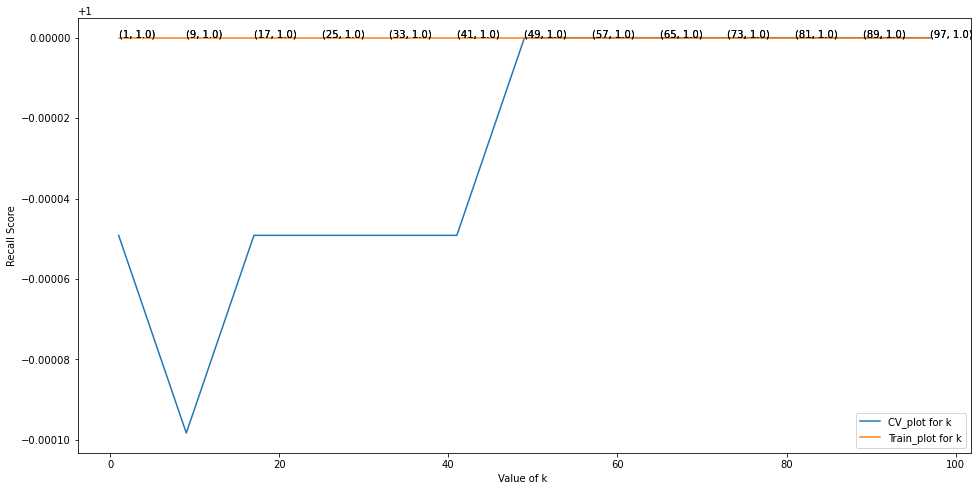

the AUC score for each k value is :  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [343]:
Scaler = StandardScaler(copy=True, with_mean=False, with_std=True).fit(X_train_rc) 
X_train_rc_std = Scaler.transform(X_train_rc)
X_test_rc_std = Scaler.transform(X_test_rc) 

opt_k = find_optimal_k(X_train_rc_std,y_train,5,'brute')


The Recall score of the KNN classifier for k = 49.000000 is 99.955772%


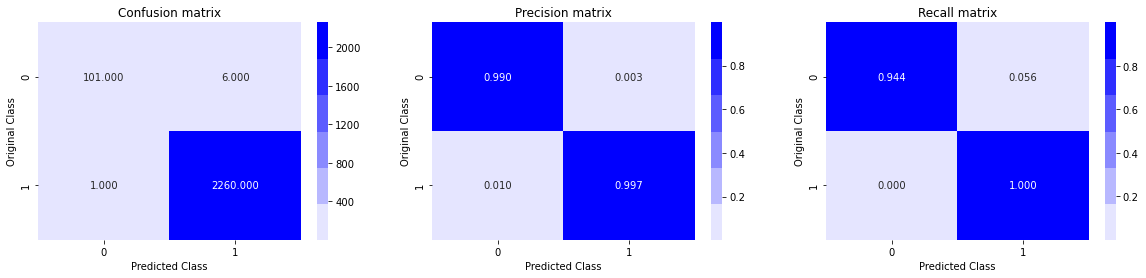

In [344]:
knn = KNeighborsClassifier(n_neighbors=opt_k,weights='distance',algorithm='brute',n_jobs=4)

# fitting the model
knn.fit(X_train_rc_std, y_train)

# predict the response
prob = knn.predict_proba(X_test_rc_std)[:,1]

pred = knn.predict(X_test_rc_std)
# evaluate accuracy
recall = recall_score(y_test, pred) * 100
print('\nThe Recall score of the KNN classifier for k = %f is %f%%' % (opt_k, recall))

plot_confusion_matrix(y_test,pred)

In [299]:
# Test the code on test dataset and provide the predictions
test_data = pd.read_csv('C:\\Users\\rahul\\Desktop\\Novartis Challenge\\Dataset\\Test.csv',encoding='utf-8')
test_data.head()


,INCIDENT_ID,DATE,X_1,X_2,X_3,X_4,X_5,X_6,X_7,X_8,X_9,X_10,X_11,X_12,X_13,X_14,X_15
0,CR_195453,01-FEB-18,0,30,35,7,3,6,4,0,5,1,174,NaN,72,119,23
1,CR_103520,05-MAR-04,0,44,44,1,3,7,1,4,6,1,316,0.0,12,29,34
2,CR_196089,27-JAN-18,0,34,33,3,5,2,7,3,0,1,316,1.0,72,0,34
3,CR_112195,18-AUG-06,7,3,2,3,5,9,8,0,5,1,174,1.0,112,87,34
4,CR_149832,31-OCT-11,0,7,8,7,3,2,7,1,5,1,174,0.0,112,93,43


In [309]:
test_data.describe

<bound method NDFrame.describe of       INCIDENT_ID       DATE  X_1  X_2  X_3  X_4  X_5  X_6  X_7  X_8  X_9  \
0       CR_195453  01-FEB-18    0   30   35    7    3    6    4    0    5   
1       CR_103520  05-MAR-04    0   44   44    1    3    7    1    4    6   
2       CR_196089  27-JAN-18    0   34   33    3    5    2    7    3    0   
3       CR_112195  18-AUG-06    7    3    2    3    5    9    8    0    5   
4       CR_149832  31-OCT-11    0    7    8    7    3    2    7    1    5   
...           ...        ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
15898    CR_44468  28-NOV-97    1   22   22    7    3   15   10    0    5   
15899   CR_158460  09-JUN-12    0   35   30    3    5    1    0    2    3   
15900   CR_115946  22-APR-06    0   26   27    9    0    6    4    2    6   
15901   CR_137663  03-APR-09    0   21   23    4    1    2    7    1    6   
15902    CR_33545  24-APR-96    0    4    4    6    5    4    2    5    6   

       X_10  X_11  X_12  X_13  X_14  X_15

In [306]:
print(sorted_data.loc[:,'X_1':'X_15'].mode())

#filling NaN values
test_data.loc[:,'X_1':'X_15'] = test_data.loc[:,'X_1':'X_15'].fillna(sorted_data.loc[:,'X_1':'X_15'].mode())
test_data.head()

X_Test = test_data.loc[:,'X_1':'X_15']

   X_1  X_2  X_3  X_4  X_5  X_6  X_7  X_8  X_9  X_10  X_11  X_12  X_13  X_14  \
0    0    4    4    6    5    1    0    1    5     1   174   1.0   103    29   

   X_15  
0    34  


In [308]:
#Getting response coded vectors

Test_x1_feature_responseCoding = np.array(get_xi_feature(alpha, "X_1", X_Test))

Test_x2_feature_responseCoding = np.array(get_xi_feature(alpha, "X_2", X_Test))

Test_x3_feature_responseCoding = np.array(get_xi_feature(alpha, "X_3", X_Test))

Test_x4_feature_responseCoding = np.array(get_xi_feature(alpha, "X_4", X_Test))

Test_x5_feature_responseCoding = np.array(get_xi_feature(alpha, "X_5", X_Test))

Test_x6_feature_responseCoding = np.array(get_xi_feature(alpha, "X_6", X_Test))

Test_x7_feature_responseCoding = np.array(get_xi_feature(alpha, "X_7", X_Test))

Test_x8_feature_responseCoding = np.array(get_xi_feature(alpha, "X_8", X_Test))

Test_x9_feature_responseCoding = np.array(get_xi_feature(alpha, "X_9", X_Test))

Test_x10_feature_responseCoding = np.array(get_xi_feature(alpha, "X_10", X_Test))

Test_x11_feature_responseCoding = np.array(get_xi_feature(alpha, "X_11", X_Test))

Test_x12_feature_responseCoding = np.array(get_xi_feature(alpha, "X_12", X_Test))

Test_x13_feature_responseCoding = np.array(get_xi_feature(alpha, "X_13", X_Test))

Test_x14_feature_responseCoding = np.array(get_xi_feature(alpha, "X_14", X_Test))

Test_x15_feature_responseCoding = np.array(get_xi_feature(alpha, "X_15", X_Test))


print("test_x1_feature_responseCoding is converted feature using respone coding method. The shape of feature:", Test_x1_feature_responseCoding.shape)

test_x1_feature_responseCoding is converted feature using respone coding method. The shape of feature: (15903, 2)


In [310]:
Test_features_responseCoding =  np.concatenate((Test_x1_feature_responseCoding,Test_x2_feature_responseCoding,Test_x3_feature_responseCoding,Test_x4_feature_responseCoding,Test_x5_feature_responseCoding,Test_x6_feature_responseCoding,Test_x7_feature_responseCoding,Test_x8_feature_responseCoding,Test_x9_feature_responseCoding,Test_x10_feature_responseCoding,Test_x11_feature_responseCoding,Test_x12_feature_responseCoding,Test_x13_feature_responseCoding,Test_x14_feature_responseCoding,Test_x15_feature_responseCoding),axis=-1)
print("Test_features_responseCoding is converted feature using respone coding method. The shape of feature:", Test_features_responseCoding.shape)

Test_features_responseCoding is converted feature using respone coding method. The shape of feature: (15903, 30)


In [311]:
X_Testf = X_Test.to_numpy().astype(int)
X_Test_rc = np.concatenate((X_Testf,Test_features_responseCoding),axis=-1)

In [316]:
X_Test_rc_std = Scaler.transform(X_Test_rc)

In [345]:
y_pred = knn.predict(X_Test_rc_std)
print(type(y_pred))
print(len(y_pred))
y_pred = y_pred.tolist()

print(type(y_pred))
print(len(y_pred))

results = test_data[['INCIDENT_ID']]
print(type(results))

results['MULTIPLE_OFFENSE'] = y_pred 
#How our final submission files look like!
print(results.head())

results.to_csv("Results_knn2.csv",index=False)


<class 'numpy.ndarray'>
15903
<class 'list'>
15903
<class 'pandas.core.frame.DataFrame'>
  INCIDENT_ID  MULTIPLE_OFFENSE
0   CR_195453                 1
1   CR_103520                 1
2   CR_196089                 1
3   CR_112195                 1
4   CR_149832                 1



The optimal value of k is 41.000000.


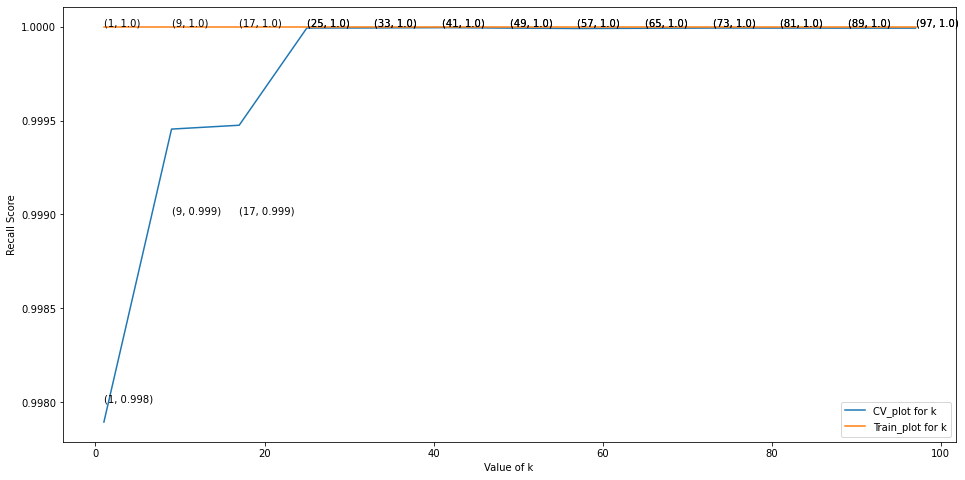

the AUC score for each k value is :  [0.998 0.999 0.999 1.    1.    1.    1.    1.    1.    1.    1.    1.
 1.   ]

The Recall score of the KNN classifier for k = 41.000000 is 100.000000%


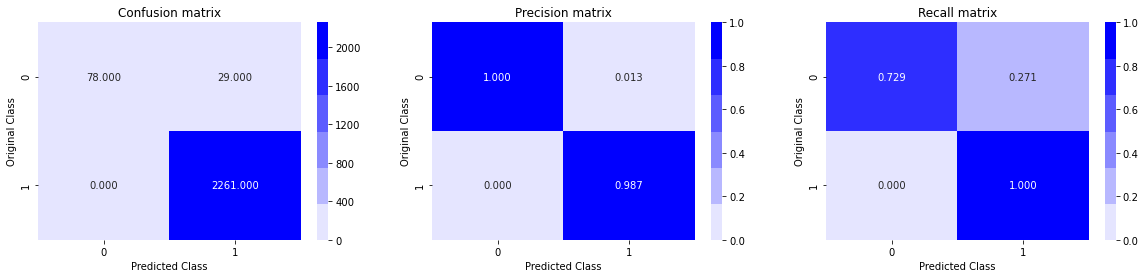

In [347]:
## Try KNN on higher dimensions(unlikely to work)

Scaler = StandardScaler(copy=True, with_mean=False, with_std=True).fit(X_train_ohe_rc) 
X_train_ohe_rc_std = Scaler.transform(X_train_ohe_rc)
X_test_ohe_rc_std = Scaler.transform(X_test_ohe_rc) 

opt_k = find_optimal_k(X_train_rc_std,y_train,5,'brute')

knn = KNeighborsClassifier(n_neighbors=opt_k,weights='distance',algorithm='brute',n_jobs=4)

# fitting the model
knn.fit(X_train_ohe_rc_std, y_train)

# predict the response
prob = knn.predict_proba(X_test_ohe_rc_std)[:,1]

pred = knn.predict(X_test_ohe_rc_std)
# evaluate accuracy
recall = recall_score(y_test, pred) * 100
print('\nThe Recall score of the KNN classifier for k = %f is %f%%' % (opt_k, recall))

plot_confusion_matrix(y_test,pred)

In [356]:
##perform one hot encoding on test data
for column in X_Test.columns:
    X_Test[column].fillna(X_Test[column].mode()[0], inplace=True)
    
# X_Test = X_Test.fillna(X_Test.loc[:,'X_1':'X_15'].mode())
print("The percentage of missing values is: {} % ".format(((len(X_Test)-X_Test.count()).sum()*100/len(X_Test)).round(3)))
X_Test = X_Test.astype(int)
X_Test_ohe = ohe.transform(X_Test).toarray()

X_Test_ohe_rc = np.concatenate((X_Test_rc,X_Test_ohe),axis=-1)
print("After converting Test data into higher dimensions,shape is: ",X_Test_ohe_rc.shape)

The percentage of missing values is: 0.0 % 
After converting Test data into higher dimensions,shape is:  (15903, 554)


## Perform Naive Bayes and Logistic Regression on Higher Dimensional data

In [362]:
def find_optimal_alpha(x,y,n):
    # creating a list of alpha for NB
    alpha_list = [0.000001,0.000001,0.00001,.0001,.001,.01,.1,1,10,100]
    tuned_parameters = [{'alpha': alpha_list}]
    model = GridSearchCV(MultinomialNB(fit_prior=False), tuned_parameters, scoring = 'roc_auc',n_jobs=-1, cv=n,return_train_score = True)
    model.fit(x,y)
        
    train_scores = model.cv_results_['mean_train_score']
    cv_scores = model.cv_results_['mean_test_score']    
    
    optimal_alpha = alpha_list[np.argmax(cv_scores)]
    print('\nThe optimal value of alpha is %f.' % optimal_alpha)
    #taking log of the values for graph to maintain the scale
    plt.figure(figsize=(16,8))

    plt.plot(alpha_list, cv_scores,label='CV_plot for alpha')
    plt.plot(alpha_list, train_scores,label= 'Train_plot for alpha')

    for xy in zip(alpha_list, np.round(cv_scores,3)):
        plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')

    for xy in zip(alpha_list, np.round(train_scores,3)):
        plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')

    plt.xlabel('Value of Alpha ')
    plt.ylabel('ROC Score')
    plt.legend()
    plt.show()

    print("the AUC score for each Alpha value is : ", np.round(cv_scores,3))

    return optimal_alpha



The optimal value of alpha is 0.000001.


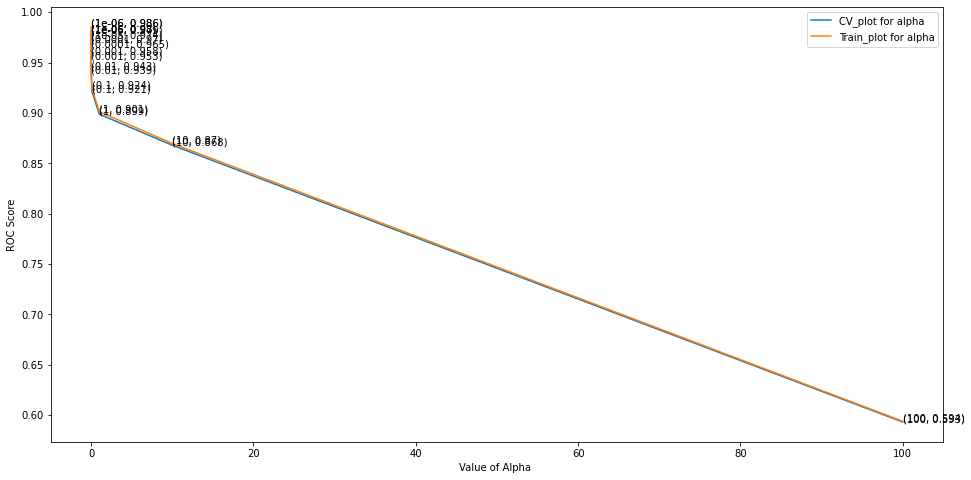

the AUC score for each Alpha value is :  [0.98  0.98  0.974 0.965 0.953 0.939 0.921 0.899 0.868 0.593]

The ROC_AUC score of the NB classifier for alpha = 0.000001 is 97.621183%


In [364]:
opt_alpha = find_optimal_alpha(X_train_ohe_rc,y_train,5)

NB_optimal = MultinomialNB(alpha=opt_alpha, fit_prior=False)

# fitting the model
NB_optimal.fit(X_train_ohe_rc, y_train)

# predict the response
prob = NB_optimal.predict_proba(X_test_ohe_rc)[:,1]

pred = NB_optimal.predict(X_test_ohe_rc)
# evaluate accuracy
roc = roc_auc_score(y_test, prob) * 100
print('\nThe ROC_AUC score of the NB classifier for alpha = %f is %f%%' % (opt_alpha, roc))


In [365]:
##Make prediction on the actual test data

y_pred = NB_optimal.predict(X_Test_ohe_rc)
y_pred = y_pred.tolist()

results = test_data[['INCIDENT_ID']]
results['MULTIPLE_OFFENSE'] = y_pred 
#How our final submission files look like!
print(results.head())

results.to_csv("Results_NB.csv",index=False)

  INCIDENT_ID  MULTIPLE_OFFENSE
0   CR_195453                 0
1   CR_103520                 1
2   CR_196089                 1
3   CR_112195                 1
4   CR_149832                 1


In [379]:
def find_optimal_plane(x,y,k):
    
    pen_list = ['l1','l2','elasticnet']
    c_grid_list = [10**-3, 10**-2,10**-1, 10**0,10**1, 10**2,10**3, 10**4,10**5]
    l1_ratio_list = [0,.25,.5,.75,1]
    
    tuned_parameters = [{'C': c_grid_list,'penalty': pen_list, 'l1_ratio': l1_ratio_list}]
    model = GridSearchCV(LogisticRegression(class_weight= 'balanced'), tuned_parameters, scoring = 'roc_auc',n_jobs=-1, cv=k)
    
    model.fit(x,y)

    scores_mean = model.cv_results_['mean_test_score']
    best = model.best_estimator_
    print("The best model obtained from our Gridsearch is: ",best)
    print("The best parameters obtained by our model is: ",model.best_params_)
    print("The AUC score for our model is is: ",np.round(model.best_score_,3))
    
    return model


In [380]:
#find the best plane for LR
opt_plane = find_optimal_plane(X_train_ohe_rc_std,y_train,5)

The best model obtained from our Gridsearch is:  LogisticRegression(C=0.1, class_weight='balanced', l1_ratio=0)
The best parameters obtained by our model is:  {'C': 0.1, 'l1_ratio': 0, 'penalty': 'l2'}
The AUC score for our model is is:  1.0



The Recall score of the LR classifier is 100.000000%

The ROC_AUC score of the NB classifier for alpha = 0.000001 is 100.000000%


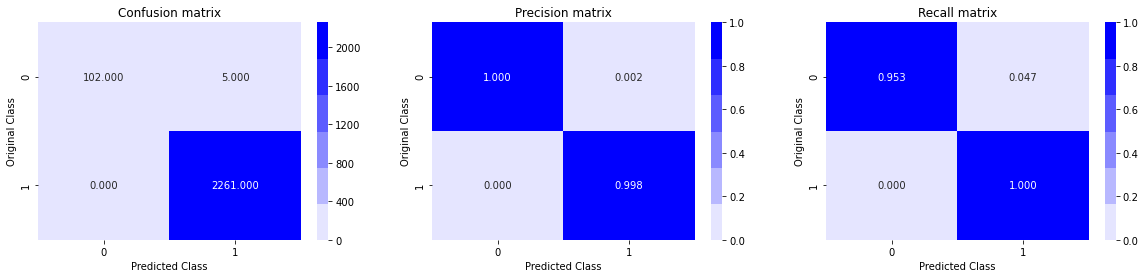

In [381]:
optimal_plane = LogisticRegression(class_weight='balanced',C=0.1,penalty='l2')

optimal_plane.fit(X_train_ohe_rc_std, y_train)
prob = optimal_plane.predict_proba(X_test_ohe_rc_std)[:,1]

pred = optimal_plane.predict(X_test_ohe_rc_std)

# evaluate accuracy
recall = recall_score(y_test, pred) * 100
print('\nThe Recall score of the LR classifier is %f%%' % (recall))

# evaluate accuracy
roc = roc_auc_score(y_test, prob) * 100
print('\nThe ROC_AUC score of the NB classifier for alpha = %f is %f%%' % (opt_alpha, roc))

plot_confusion_matrix(y_test,pred)


In [376]:
#Try without class balancing
def find_optimal_unb_plane(x,y,k):
    
    pen_list = ['l1','l2','elasticnet']
    c_grid_list = [10**-3, 10**-2,10**-1, 10**0,10**1, 10**2,10**3, 10**4,10**5]
    l1_ratio_list = [0,.25,.5,.75,1]
    
    tuned_parameters = [{'C': c_grid_list,'penalty': pen_list, 'l1_ratio': l1_ratio_list}]
    model = GridSearchCV(LogisticRegression(), tuned_parameters, scoring = 'roc_auc',n_jobs=-1, cv=k)
    
    model.fit(x,y)

    scores_mean = model.cv_results_['mean_test_score']
    best = model.best_estimator_
    print("The best model obtained from our Gridsearch is: ",best)
    print("The best parameters obtained by our model is: ",model.best_params_)
    print("The AUC score for our model is is: ",np.round(model.best_score_,3))
    
    return model


#find the best plane for LR 
opt_plane = find_optimal_unb_plane(X_train_ohe_rc_std,y_train,5)



The best model obtained from our Gridsearch is:  LogisticRegression(C=0.1, l1_ratio=0)
The best parameters obtained by our model is:  {'C': 0.1, 'l1_ratio': 0, 'penalty': 'l2'}
The AUC score for our model is is:  1.0



The Recall score of the LR classifier is 100.000000%

The ROC_AUC score of the LR classifier for is 100.000000%


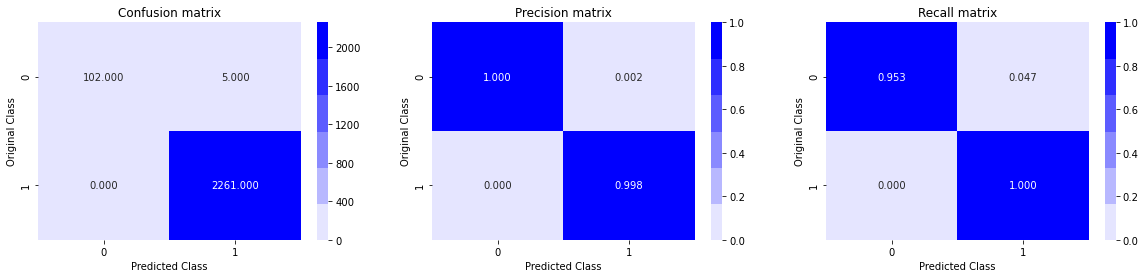

In [377]:
optimal_plane = LogisticRegression(C=0.1,penalty='l2')
optimal_plane.fit(X_train_ohe_rc_std, y_train)
prob = optimal_plane.predict_proba(X_test_ohe_rc_std)[:,1]

pred = optimal_plane.predict(X_test_ohe_rc_std)

# evaluate accuracy
recall = recall_score(y_test, pred) * 100
print('\nThe Recall score of the LR classifier is %f%%' % (recall))

# evaluate accuracy
roc = roc_auc_score(y_test, prob) * 100
print('\nThe ROC_AUC score of the LR classifier for is %f%%' % (roc))

plot_confusion_matrix(y_test,pred)

In [378]:
X_Test_ohe_rc_std = Scaler.transform(X_Test_ohe_rc)

y_pred = optimal_plane.predict(X_Test_ohe_rc_std)
print(type(y_pred))
y_pred = y_pred.tolist()

results = test_data[['INCIDENT_ID']]
print(type(results))

results['MULTIPLE_OFFENSE'] = y_pred 
#How our final submission files look like!
print(results.head())

results.to_csv("Results_LR.csv",index=False)


<class 'numpy.ndarray'>
<class 'pandas.core.frame.DataFrame'>
  INCIDENT_ID  MULTIPLE_OFFENSE
0   CR_195453                 1
1   CR_103520                 1
2   CR_196089                 1
3   CR_112195                 1
4   CR_149832                 1


In [382]:
# TRy LR on Response vectors alone(lesser dims unlikely to work)

#find the best plane for LR 
opt_plane = find_optimal_plane(X_train_rc_std,y_train,5)

The best model obtained from our Gridsearch is:  LogisticRegression(C=0.001, class_weight='balanced', l1_ratio=0)
The best parameters obtained by our model is:  {'C': 0.001, 'l1_ratio': 0, 'penalty': 'l2'}
The AUC score for our model is is:  1.0



The Recall score of the LR classifier is 100.000000%

The ROC_AUC score of the LR classifier for is 100.000000%


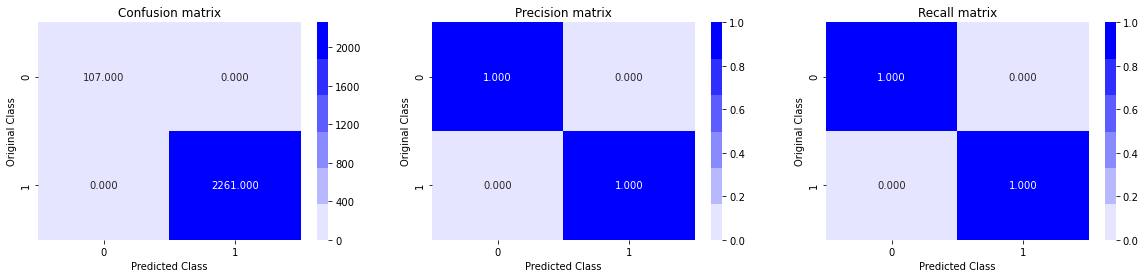

In [383]:
optimal_plane = LogisticRegression(class_weight='balanced',C=0.001,penalty='l2')
optimal_plane.fit(X_train_rc_std, y_train)
prob = optimal_plane.predict_proba(X_test_rc_std)[:,1]

pred = optimal_plane.predict(X_test_rc_std)

# evaluate accuracy
recall = recall_score(y_test, pred) * 100
print('\nThe Recall score of the LR classifier is %f%%' % (recall))

# evaluate accuracy
roc = roc_auc_score(y_test, prob) * 100
print('\nThe ROC_AUC score of the LR classifier for is %f%%' % (roc))

plot_confusion_matrix(y_test,pred)

In [385]:
#looks very promising

y_pred = optimal_plane.predict(X_Test_rc_std)
print(type(y_pred))
y_pred = y_pred.tolist()

results = test_data[['INCIDENT_ID']]
print(type(results))

results['MULTIPLE_OFFENSE'] = y_pred 
#How our final submission files look like!
print(results.head())

results.to_csv("Results_LR2.csv",index=False)


<class 'numpy.ndarray'>
<class 'pandas.core.frame.DataFrame'>
  INCIDENT_ID  MULTIPLE_OFFENSE
0   CR_195453                 1
1   CR_103520                 1
2   CR_196089                 1
3   CR_112195                 1
4   CR_149832                 1


In [408]:
#USE SVMs as they work well on imbalanced data theoretically

def find_optimal_plane_svm(x,y,k):
    
    alpha_grid_list = [10**-4,10**-3, 10**-2,10**-1, 10**0,10**1, 10**2,10**3, 10**4]
    pen_list = ['l1','l2','elasticnet']
    l1_ratio = [0,.25,.5,.75,1]
    tuned_parameters = [{'alpha': alpha_grid_list,'penalty': pen_list,'l1_ratio': l1_ratio}]
    model = GridSearchCV(SGDClassifier(class_weight='balanced',loss='hinge'), tuned_parameters, scoring = 'roc_auc',n_jobs=-1, cv=k,return_train_score = True)
    model.fit(x,y)

    scores_mean = model.cv_results_['mean_test_score']
    best = model.best_estimator_
    print("The best model obtained from our Gridsearch is: ",best)
    print("The best parameters obtained by our model is: ",model.best_params_)
    print("The AUC score for our model is is: ",np.round(model.best_score_,3))
    
    return model 

#find the best plane for SVM 
opt_plane = find_optimal_plane_svm(X_train_ohe_rc_std,y_train,5)


The best model obtained from our Gridsearch is:  SGDClassifier(alpha=0.1, class_weight='balanced', l1_ratio=0.25,
              penalty='elasticnet')
The best parameters obtained by our model is:  {'alpha': 0.1, 'l1_ratio': 0.25, 'penalty': 'elasticnet'}
The AUC score for our model is is:  1.0



The Recall score of the LR classifier is 100.000000%


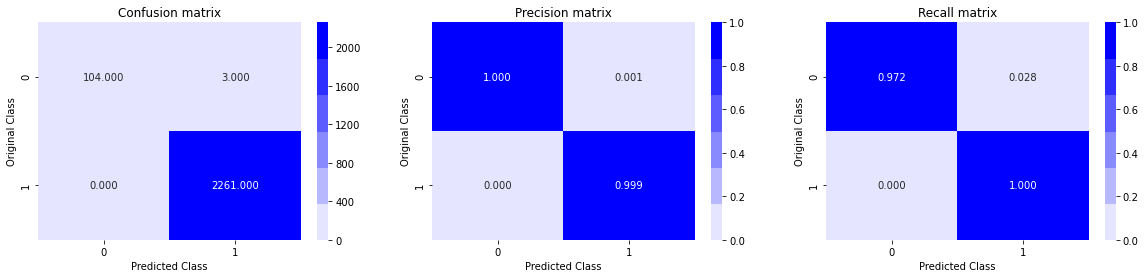

In [410]:
optimal_plane = SGDClassifier(alpha=0.1, class_weight='balanced', l1_ratio=0.25,
              penalty='elasticnet')

optimal_plane.fit(X_train_rc_std, y_train)

pred = optimal_plane.predict(X_test_rc_std)
# evaluate accuracy
recall = recall_score(y_test, pred) * 100
print('\nThe Recall score of the LR classifier is %f%%' % (recall))

plot_confusion_matrix(y_test,pred)

In [411]:
#looks very promising

y_pred = optimal_plane.predict(X_Test_rc_std)
print(type(y_pred))
y_pred = y_pred.tolist()

results = test_data[['INCIDENT_ID']]
print(type(results))

results['MULTIPLE_OFFENSE'] = y_pred 
#How our final submission files look like!
print(results.head())

results.to_csv("Results_SVM.csv",index=False)

<class 'numpy.ndarray'>
<class 'pandas.core.frame.DataFrame'>
  INCIDENT_ID  MULTIPLE_OFFENSE
0   CR_195453                 1
1   CR_103520                 1
2   CR_196089                 1
3   CR_112195                 1
4   CR_149832                 1


## Try powerful tree based models



In [387]:
#function to find the optimal lambda in LR for 5 fold cross validation
def find_optimal_forest(x,y,k):
    
    depth_grid_list = [4,8,12,16,20,24]
    estimators_grid_list =  [25,50,100,150,200,250]
    oob_bool = [True,False]
    tuned_parameters = [{'max_depth': depth_grid_list, 'n_estimators': estimators_grid_list,'oob_score': oob_bool}]
    model = GridSearchCV(RandomForestClassifier(class_weight='balanced'), tuned_parameters, scoring = 'roc_auc',n_jobs=-1, cv=k,return_train_score = True)
    model.fit(x,y)
    
    best = model.best_estimator_
    print("The best model obtained from our Gridsearch is: ",best)
    print("The best parameters obtained by our model is: ",model.best_params_)
    print("The AUC score for our model is is: ",np.round(model.best_score_,3))
    
    return model


In [388]:
opt_forest = find_optimal_forest(X_train_rc_std,y_train,5)

The best model obtained from our Gridsearch is:  RandomForestClassifier(class_weight='balanced', max_depth=8, n_estimators=25)
The best parameters obtained by our model is:  {'max_depth': 8, 'n_estimators': 25, 'oob_score': False}
The AUC score for our model is is:  1.0



The Recall score of the RF classifier is 100.000000%

The ROC_AUC score of the RF classifier for is 100.000000%


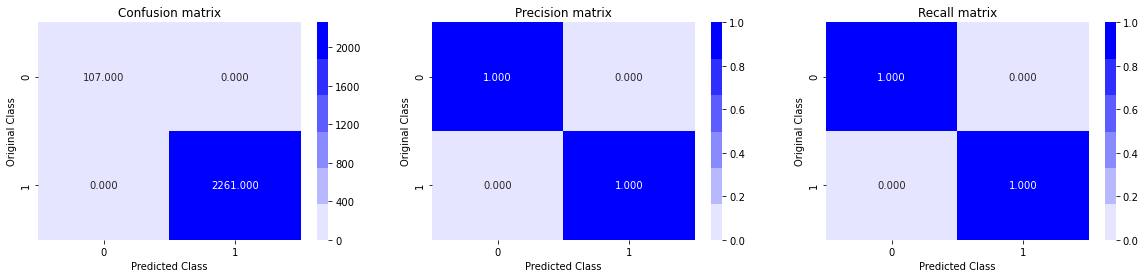

In [415]:
optimal_forest = RandomForestClassifier(class_weight='balanced', max_depth=8, n_estimators=25)

optimal_forest.fit(X_train_rc_std, y_train)
prob = optimal_forest.predict_proba(X_test_rc_std)[:,1]

pred = optimal_forest.predict(X_test_rc_std)

# evaluate accuracy
recall = recall_score(y_test, pred) * 100
print('\nThe Recall score of the RF classifier is %f%%' % (recall))

# evaluate accuracy
roc = roc_auc_score(y_test, prob) * 100
print('\nThe ROC_AUC score of the RF classifier for is %f%%' % (roc))

plot_confusion_matrix(y_test,pred)

In [416]:
#looks very promising

y_pred = optimal_forest.predict(X_Test_rc_std)
print(type(y_pred))
y_pred = y_pred.tolist()

results = test_data[['INCIDENT_ID']]
print(type(results))

results['MULTIPLE_OFFENSE'] = y_pred 
#How our final submission files look like!
print(results.head())

results.to_csv("Results_RF.csv",index=False)


<class 'numpy.ndarray'>
<class 'pandas.core.frame.DataFrame'>
  INCIDENT_ID  MULTIPLE_OFFENSE
0   CR_195453                 1
1   CR_103520                 1
2   CR_196089                 1
3   CR_112195                 1
4   CR_149832                 1


In [414]:
def find_optimal_gbdt(x,y,k,weight):
    
    params = {  
    "n_estimators": st.randint(5, 100),
    "max_depth": st.randint(2, 25),
    "learning_rate": st.uniform(0, 0.25),
    "gamma": st.uniform(0,5)}

    model = RandomizedSearchCV(XGBClassifier(scale_pos_weight=weight), params, scoring = 'roc_auc',n_jobs=-1, cv=k,return_train_score = True)
    model.fit(x,y)
    
    best = model.best_estimator_
    print("The best model obtained from our Gridsearch is: ",best)
    print("The best parameters obtained by our model is: ",model.best_params_)
    print("The AUC score for our model is is: ",np.round(model.best_score_,3))
    
    return model

#subtractign by 182 as all the NaN values belonged to majority class
weight = sum(X_train['MULTIPLE_OFFENSE']==0)/(sum(X_train['MULTIPLE_OFFENSE']==1)-182)
weight = round(weight,3)

opt_gbdt = find_optimal_gbdt(X_train_rc_std,y_train,5,weight)

The best model obtained from our Gridsearch is:  XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=1.3340812165162041,
              gpu_id=-1, importance_type='gain', interaction_constraints=None,
              learning_rate=0.06799882765873583, max_delta_step=0, max_depth=14,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=64, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=0.048, subsample=1,
              tree_method=None, validate_parameters=False, verbosity=None)
The best parameters obtained by our model is:  {'gamma': 1.3340812165162041, 'learning_rate': 0.06799882765873583, 'max_depth': 14, 'n_estimators': 64}
The AUC score for our model is is:  1.0


## FINAL EVALUATION MODEL (to be considered for submission) : ##


The Recall score of the LR classifier is 99.955772%

The ROC_AUC score of the LR classifier for is 100.000000%


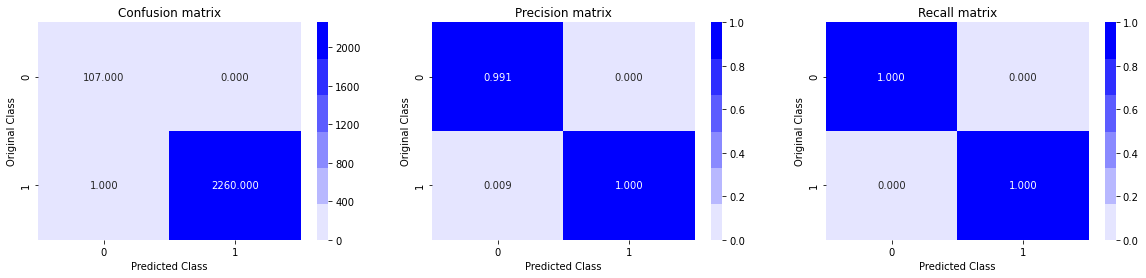

In [418]:
optimal_gbdt = XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=1.3340812165162041,
              gpu_id=-1, importance_type='gain', interaction_constraints=None,
              learning_rate=0.06799882765873583, max_delta_step=0, max_depth=14,
              min_child_weight=1,  monotone_constraints=None,
              n_estimators=64, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=0.048, subsample=1,
              tree_method=None, validate_parameters=False, verbosity=None)

optimal_gbdt.fit(X_train_rc_std, y_train)
prob = optimal_gbdt.predict_proba(X_test_rc_std)[:,1]

pred = optimal_gbdt.predict(X_test_rc_std)

# evaluate accuracy
recall = recall_score(y_test, pred) * 100
print('\nThe Recall score of the LR classifier is %f%%' % (recall))

# evaluate accuracy
roc = roc_auc_score(y_test, prob) * 100
print('\nThe ROC_AUC score of the LR classifier for is %f%%' % (roc))

plot_confusion_matrix(y_test,pred)

In [419]:
#looks very promising

y_pred = optimal_gbdt.predict(X_Test_rc_std)
print(type(y_pred))
y_pred = y_pred.tolist()

results = test_data[['INCIDENT_ID']]
print(type(results))

results['MULTIPLE_OFFENSE'] = y_pred 
#How our final submission files look like!
print(results.head())

results.to_csv("Results_GBDT.csv",index=False)


<class 'numpy.ndarray'>
<class 'pandas.core.frame.DataFrame'>
  INCIDENT_ID  MULTIPLE_OFFENSE
0   CR_195453                 1
1   CR_103520                 1
2   CR_196089                 1
3   CR_112195                 1
4   CR_149832                 1


## CONCLUSIONS :

    1. The dataset was relatively low dimensional, with anonymized variables which were categorical in nature.
    2. We tried a bunch of featurizations such as Response Coding(with smoothing),One hot encoding among others.
    3. Since the dates were available, we tried temporal splitting, by correcting the dates into right format. But since test file was already available, it was seen that test data wasn't based on time, However time based slicing could help in future unseen data which we do not know about.
    4. We started with simple models such as KNN, linear models and then proceeded with complex models. 
    5. Almost all models performed well on lower dimensions, interestingly even linear models such as LR did not perform upto the mark on higher dimensions. This shows that OHE was not a good choice of featurization as opposed to Response Coding.
    6. As expected, powerful models such as RF and GBDT with tuning outperformed all other models. Even though GBDT had a slight error in our test split, it generalized better than RF model on the Test file that was provided to us without the class labels.
    7. We had reserved a small subset of data(10%) for us to check the performance on unseen data, but this also comes with a flip side as model could be even more powerful with more train data ! 
    8. Although all models are present in the notebook, I request the team to consider the final GBDT model for submission and the file generated by it on (cell 419) for evaluation. 